# New York City Taxi Fare Data Exploration

## Reading data and first exploration


First thing I like to do with a new dataset is to explore the data. This means investigating the number of features, their datatype, their meaning and statistics.

In [1]:
# load some default Python modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from google.cloud import bigquery
from pprint import pprint
import os
import folium
import geopandas
from datetime import date, datetime
import contextily as cx
import matplotlib.pyplot as plt


/Users/jnapolitano/venvs/finance/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


As this dataset is huge reading all data would require a lot of memory. Therefore I read a limited number of rows while exploring the data. When my exploration code (e.g. this notebook) is ready I re-run the notebook while reading more rows.

## Querying the Green Cab Data Set.

The queries below clean the data and prepare it for analysis. 

### SQL Import Functions

In [2]:
def query_big_query(query_string):
    client = bigquery.Client()
    query_job = client.query(query_string)

    results = query_job.result()  # Waits for job to complete.
    return results

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/jnapolitano/Projects/pmc-submission/creds.json"

In [4]:
def clean_up_data():

  query_string = """
      SELECT 
      t.*,
      FROM
      (
      SELECT *,
      TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) as time_duration_in_secs,
      TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as time_duration_in_mins,
      ROUND(trip_distance/TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND),2)*3600 as driving_speed_miles_per_hour,
      (CASE WHEN total_amount=0 THEN 0
      ELSE ROUND(tip_amount*100/total_amount,2) END) as tip_rate,
      EXTRACT(YEAR from pickup_datetime) as pickup_year,
      EXTRACT(MONTH from pickup_datetime) as pickup_month,
      CONCAT(CAST(EXTRACT(YEAR from pickup_datetime) as STRING),"-",CAST(EXTRACT(MONTH from pickup_datetime) AS STRING)) as pickup_yearmonth,
      EXTRACT(DATE from pickup_datetime) as pickup_date,
      FORMAT_DATE('%A',DATE(pickup_datetime)) as pickup_weekday_name,
      EXTRACT(HOUR from pickup_datetime) as pickup_hour,
      EXTRACT(YEAR from dropoff_datetime) as dropoff_year,
      EXTRACT(MONTH from dropoff_datetime) as dropoff_month,
      CONCAT(CAST(EXTRACT(YEAR from dropoff_datetime) as STRING),"-",CAST(EXTRACT(MONTH from dropoff_datetime) AS STRING)) as dropoff_yearmonth,
      EXTRACT(DATE from dropoff_datetime) as dropoff_date,
      FORMAT_DATE('%A',DATE(dropoff_datetime)) as dropoff_weekday_name,
      EXTRACT(HOUR from dropoff_datetime) as dropoff_hour
      FROM `nyc-tlc.green.trips_2015`
      /* filter by latitude & longitude that are within the correct range */
      WHERE 
          ((pickup_latitude BETWEEN -90 AND 90) AND
            (pickup_longitude BETWEEN -180 AND 180)) 
            AND
              ((dropoff_latitude BETWEEN -90 AND 90) AND
              (dropoff_longitude BETWEEN -180 AND 180))
      ) t
      WHERE 
      pickup_datetime BETWEEN '2015-01-01' AND '2016-12-31' 
      AND dropoff_datetime BETWEEN '2015-01-01' AND '2016-12-31'
      AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) > 0
      AND passenger_count > 0
      AND trip_distance >= 0 
      AND tip_amount >= 0 
      AND tolls_amount >= 0 
      AND mta_tax >= 0 
      AND fare_amount >= 0
      AND total_amount >= 0
      order by pickup_date DESC
      limit 1000000
      """


  result = query_big_query(query_string)
      
  return result.to_dataframe()

clean_df = clean_up_data()

In [5]:
# read data in pandas dataframe


# list first few rows (datapoints)
clean_df.head()

pickup_datetime          dropoff_datetime store_and_fwd_flag  \
0 2015-06-30 16:11:08+00:00 2015-06-30 16:18:33+00:00                  N   
1 2015-06-30 14:06:56+00:00 2015-06-30 14:44:59+00:00                  N   
2 2015-06-30 08:50:52+00:00 2015-06-30 08:56:16+00:00                  N   
3 2015-06-30 03:55:39+00:00 2015-06-30 04:09:03+00:00                  N   
4 2015-06-30 01:38:08+00:00 2015-06-30 01:55:25+00:00                  N   

   rate_code  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          1        -73.943321        40.785267         -73.935303   
1          1        -73.951302        40.689251         -73.999634   
2          1        -73.944077        40.721775         -73.944504   
3          1        -73.854630        40.742798         -73.905746   
4          1        -73.910698        40.658485         -73.971657   

   dropoff_latitude  passenger_count  trip_distance  ...  pickup_yearmonth  \
0         40.800449                1           1.49  ...            2015-6   
1         40.634769                1           5.74  ...            2015-6   
2         40.714703                1           0.63  ...            2015-6   
3         40.747269                2           3.26  ...            2015-6   
4         40.697437                1           5.35  ...            2015-6   

   pickup_date  pickup_weekday_name  pickup_hour  dropoff_year  dropoff_month  \
0   2015-06-30              Tuesday           16          2015              6   
1   2015-06-30              Tuesday           14          2015              6   
2   2015-06-30              Tuesday            8          2015              6   
3   2015-06-30              Tuesday            3          2015              6   
4   2015-06-30              Tuesday            1          2015              6   

   dropoff_yearmonth  dropoff_date  dropoff_weekday_name  dropoff_hour  
0             2015-6    2015-06-30               Tuesday            16  
1             2015-6    2015-06-30               Tuesday            14  
2             2015-6    2015-06-30               Tuesday             8  
3             2015-6    2015-06-30               Tuesday             4  
4             2015-6    2015-06-30               Tuesday             1  

[5 rows x 37 columns]

In [6]:
# check datatypes
clean_df.dtypes

pickup_datetime                 datetime64[ns, UTC]
dropoff_datetime                datetime64[ns, UTC]
store_and_fwd_flag                           object
rate_code                                     Int64
pickup_longitude                            float64
pickup_latitude                             float64
dropoff_longitude                           float64
dropoff_latitude                            float64
passenger_count                               Int64
trip_distance                               float64
fare_amount                                 float64
extra                                       float64
mta_tax                                     float64
tip_amount                                  float64
tolls_amount                                float64
ehail_fee                                   float64
total_amount                                float64
payment_type                                  Int64
distance_between_service                    float64
time_between

In [7]:
# check statistics of the features
clean_df.describe()

rate_code  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  1000000.000000    1000000.000000   1000000.000000     1000000.000000   
mean         1.099227        -73.837842        40.695889         -73.880229   
std          0.611234          2.669467         1.472229           1.975514   
min          1.000000        -75.845970         0.000000         -75.845978   
25%          1.000000        -73.958794        40.699097         -73.966631   
50%          1.000000        -73.944382        40.746868         -73.943459   
75%          1.000000        -73.914879        40.802990         -73.907227   
max          6.000000          0.000000        42.464546           0.000000   

       dropoff_latitude  passenger_count   trip_distance     fare_amount  \
count    1000000.000000   1000000.000000  1000000.000000  1000000.000000   
mean          40.717875         1.381162        2.906045       12.525830   
std            1.089994         1.054405        2.986171       10.911337   
min            0.000000         1.000000        0.000000        0.000000   
25%           40.699371         1.000000        1.090000        6.500000   
50%           40.747639         1.000000        1.930000        9.500000   
75%           40.791172         1.000000        3.670000       15.000000   
max           42.464554         9.000000      210.300000     1008.500000   

                extra         mta_tax  ...  time_duration_in_secs  \
count  1000000.000000  1000000.000000  ...         1000000.000000   
mean         0.344684        0.487888  ...             882.663591   
std          0.362626        0.076872  ...            2706.093278   
min          0.000000        0.000000  ...               1.000000   
25%          0.000000        0.500000  ...             371.000000   
50%          0.500000        0.500000  ...             622.000000   
75%          0.500000        0.500000  ...            1029.000000   
max          2.500000        0.500000  ...           86368.000000   

       time_duration_in_mins  driving_speed_miles_per_hour        tip_rate  \
count         1000000.000000                1000000.000000  1000000.000000   
mean               14.223966                      7.781940        6.415084   
std                45.101709                    142.204973        8.870430   
min                 0.000000                      0.000000        0.000000   
25%                 6.000000                      0.000000        0.000000   
50%                10.000000                      0.000000        0.000000   
75%                17.000000                      0.000000       16.670000   
max              1439.000000                  36540.000000      100.000000   

       pickup_year  pickup_month     pickup_hour  dropoff_year  \
count    1000000.0     1000000.0  1000000.000000     1000000.0   
mean        2015.0           6.0       13.324359        2015.0   
std            0.0           0.0        6.894272           0.0   
min         2015.0           6.0        0.000000        2015.0   
25%         2015.0           6.0        9.000000        2015.0   
50%         2015.0           6.0       15.000000        2015.0   
75%         2015.0           6.0       19.000000        2015.0   
max         2015.0           6.0       23.000000        2015.0   

        dropoff_month    dropoff_hour  
count  1000000.000000  1000000.000000  
mean         6.000423       13.277533  
std          0.020563        6.969866  
min          6.000000        0.000000  
25%          6.000000        8.000000  
50%          6.000000       15.000000  
75%          6.000000       19.000000  
max          7.000000       23.000000  

[8 rows x 28 columns]

Checking for negative values and anything else I missed from the initial sql clean:

In [8]:
print('Old size: %d' % len(clean_df))
clean_df = clean_df[clean_df.fare_amount>=0]
print('New size: %d' % len(clean_df))

Old size: 1000000


New size: 1000000


No negative values reported.

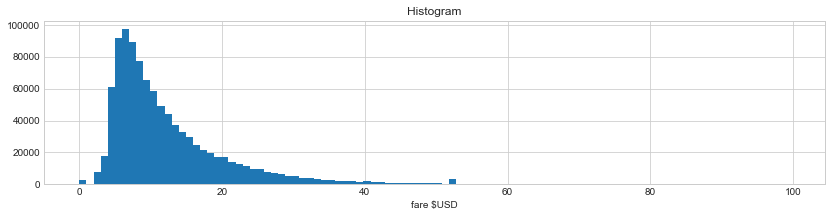

In [9]:
# plot histogram of fare
clean_df[clean_df.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

In the histogram of the `fare_amount` there are some small spikes between \$40 and \$55. This could indicate some fixed fare price (e.g. to/from airport). This will be explored further.

Also the graph is unusually not biased towards the right.  The minimaal rate must reduce the possibility of a normal distribution.  

## Remove missing data

Always check to see if there is missing data. As this dataset is huge, removing datapoints with missing data probably has no effect on the models beings trained.

In [10]:
print(clean_df.isnull().sum())

pickup_datetime                       0
dropoff_datetime                      0
store_and_fwd_flag                    0
rate_code                             0
pickup_longitude                      0
pickup_latitude                       0
dropoff_longitude                     0
dropoff_latitude                      0
passenger_count                       0
trip_distance                         0
fare_amount                           0
extra                                 0
mta_tax                               0
tip_amount                            0
tolls_amount                          0
ehail_fee                       1000000
total_amount                          0
payment_type                          0
distance_between_service              0
time_between_service                  0
trip_type                             0
time_duration_in_secs                 0
time_duration_in_mins                 0
driving_speed_miles_per_hour          0
tip_rate                              0


The only data points with null are thee ehail_fees.  It is negative a cross every data point.  I'l just drop the column

In [11]:
print('Old size: %d' % (clean_df.size))
clean_df= clean_df.loc[:, clean_df.columns != "ehail_fee"]
print('New size: %d' % (clean_df.size))

Old size: 37000000
New size: 36000000


## Location data

As we're dealing with location data, I want to plot the coordinates on a map. This gives a better view of the data. For this, I use the following website:

- Easy to use map and GPS tool: https://www.gps-coordinates.net/ 
- Calculate distance between locations: https://www.travelmath.com/flying-distance/
- Open street map to grab using bouding box a map: https://www.openstreetmap.org/export#map=8/52.154/5.295

New York city coordinates are (https://www.travelmath.com/cities/New+York,+NY):

- longitude = -74.0063889
- lattitude = 40.7141667

I define a bounding box of interest by [long_min, long_max, latt_min, latt_max] using the minimum and maximum coordinates from the testset. This way, I'm sure to train a model for the full pickup/dropoff coordinate range of the test set.

From Open Street Map I grab a map and I drop any datapoint outside this box.

In [12]:
# minimum and maximum longitude test set
min(clean_df.pickup_longitude.min(), clean_df.dropoff_longitude.min()), \
max(clean_df.pickup_longitude.max(), clean_df.dropoff_longitude.max())

(-75.84597778320312, 0.0)

In [13]:
# minimum and maximum latitude test
min(clean_df.pickup_latitude.min(), clean_df.dropoff_latitude.min()), \
max(clean_df.pickup_latitude.max(), clean_df.dropoff_latitude.max())

(0.0, 42.46455383300781)

In [14]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
#nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
#nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [15]:
print('Old size: %d' % len(clean_df))
clean_df = clean_df[select_within_boundingbox(clean_df, BB)]
print('New size: %d' % len(clean_df))

Old size: 1000000


New size: 998236


### Adding a Geometry column to the table

In [16]:

def json_serial(obj):
    """JSON serializer for objects not serializable by default json code"""

    if isinstance(obj, (datetime, date)):
        return obj.isoformat()
    raise TypeError ("Type %s not serializable" % type(obj))

In [17]:

gdf = geopandas.GeoDataFrame(
    clean_df, geometry=geopandas.points_from_xy(clean_df.pickup_longitude, clean_df.pickup_latitude))

When using interactie maps, all of the columns within a df must be json seriable to interact with apis.  The code below serializes all of the date columns for plottin.  

In [18]:
gdf.pickup_datetime = gdf.pickup_datetime.map(json_serial)
gdf.dropoff_datetime = gdf.dropoff_datetime.map(json_serial)
gdf.dropoff_date =  gdf.dropoff_date.map(json_serial)
gdf.pickup_date = gdf.pickup_date.map(json_serial)

In [19]:
gdf.dtypes


pickup_datetime                   object
dropoff_datetime                  object
store_and_fwd_flag                object
rate_code                          Int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    Int64
trip_distance                    float64
fare_amount                      float64
extra                            float64
mta_tax                          float64
tip_amount                       float64
tolls_amount                     float64
total_amount                     float64
payment_type                       Int64
distance_between_service         float64
time_between_service               Int64
trip_type                          Int64
time_duration_in_secs              Int64
time_duration_in_mins              Int64
driving_speed_miles_per_hour     float64
tip_rate                         float64
pickup_year     

### Checking Coordinate System

In [20]:
#gdf = EPSG:3857
gdf.crs = "EPSG:4236"
gdf = gdf.to_crs(epsg=3857)

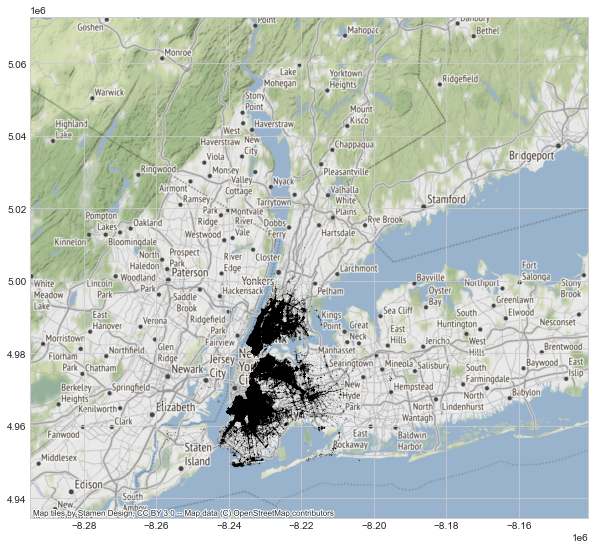

In [21]:
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', markersize = .01)
cx.add_basemap(ax,)


### Datapoint density per sq mile


A scatterplot of the pickup and dropoff locations gives a quick impression of the density. However, it is more accurate to count the number of datapoints per area to visualize the density. The code below counts pickup and dropoff datapoints per sq miles. This gives a better view on the 'hot spots'.

In [22]:
# For this plot and further analysis, we need a function to calculate the distance in miles between locations in lon,lat coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

# First calculate two arrays with datapoint density per sq mile
n_lon, n_lat = 200, 200 # number of grid bins per longitude, latitude dimension
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # prepare arrays

# To calculate the number of datapoints in a grid area, the numpy.digitize() function is used. 
# This function needs an array with the (location) bins for counting the number of datapoints
# per bin.
bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin
delta_lon = (BB[1]-BB[0]) / n_lon # bin longutide width
delta_lat = (BB[3]-BB[2]) / n_lat # bin latitude height
bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon # bin width in miles
bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat # bin height in miles
for i in range(n_lon+1):
    bins_lon[i] = BB[0] + i * delta_lon
for j in range(n_lat+1):
    bins_lat[j] = BB[2] + j * delta_lat
    
# Digitize per longitude, latitude dimension
inds_pickup_lon = np.digitize(clean_df.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(clean_df.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(clean_df.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(clean_df.dropoff_latitude, bins_lat)

# Count per grid bin
# note: as the density_pickup will be displayed as image, the first index is the y-direction, 
#       the second index is the x-direction. Also, the y-direction needs to be reversed for
#       properly displaying (therefore the (n_lat-j) term)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

/var/folders/kw/lt24g6yd1ml1zznc5n22lbb00000gn/T/ipykernel_15204/3595766640.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im, ax=axs[0])


/var/folders/kw/lt24g6yd1ml1zznc5n22lbb00000gn/T/ipykernel_15204/3595766640.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im, ax=axs[1])


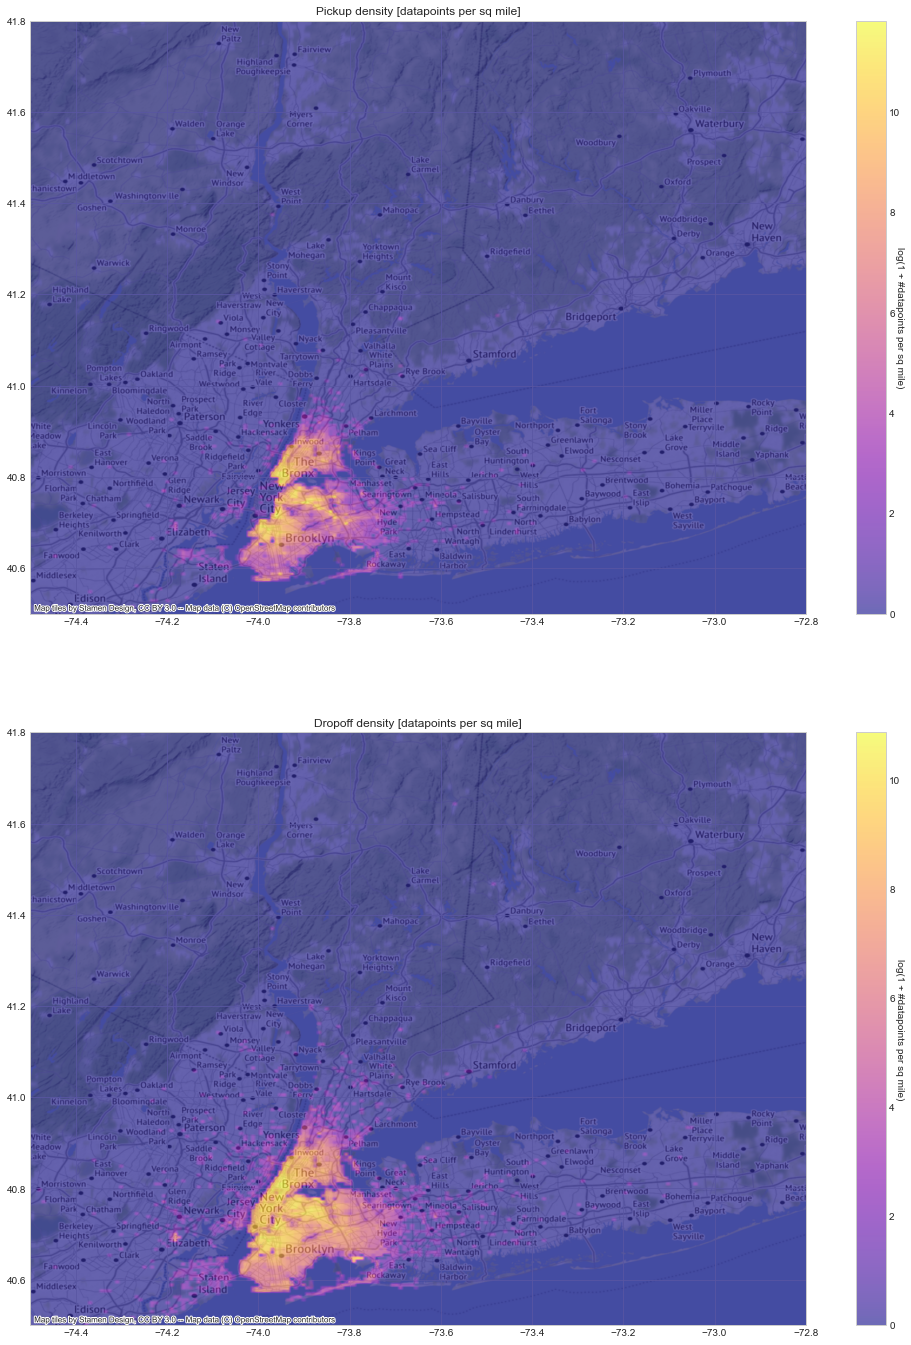

In [23]:
# Plot the density arrays
fig, axs = plt.subplots(2, 1, figsize=(18, 24))
#axs[0].imshow(nyc_map, zorder=0, extent=BB);
im = axs[0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[0].set_title('Pickup density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)
cx.add_basemap(axs[0],crs=4236)

#axs[1].imshow(nyc_map, zorder=0, extent=BB);
im = axs[1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
cx.add_basemap(axs[1],crs=4236)
axs[1].set_title('Dropoff density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)


These plots clearly show that the datapoints concentrate around Manhatten and the three airports (JFK, EWS, LGR).


## Pickup traffic density
The density plots of above triggered me to see if I can visualize traffic density by the hour (and year). By counting the number of pickups in an area we should get some impression of the traffic density. The more traffic, the longer it could take to make a drive.

In [24]:
# add time information
labels = {'monday' : 0, 'tuesday' : 1, 'wednesday' : 2, 'thursday' : 3, 'friday' : 4, 'saturday' : 5, 'sunday' : 6}
gdf['pickup_weekday_name_test'] = gdf["pickup_weekday_name"]
gdf.pickup_weekday_name = gdf['pickup_weekday_name'].apply(str.lower)
gdf.dropoff_weekday_name = gdf['dropoff_weekday_name'].apply(str.lower)

gdf['pickup_codes'] = gdf.pickup_weekday_name.map(labels)
gdf['dropoff_codes'] = gdf.dropoff_weekday_name.map(labels)

In [25]:
# some constants needed to calculate pickup traffic density
n_hours = 24
n_weekdays = 7
n_years = 7
n_bins_lon = 30
n_bins_lat = 30

# focus on traffic in Manhattan
BB_traffic = (-74.5, -72.8, 40.5, 41.8)

# define function to calculate pickup traffic density
def calculate_trafic_density(df):
    traffic = np.zeros((n_years, n_weekdays, n_hours, n_bins_lat, n_bins_lon))
    
    # To calculate the number of datapoints in a grid area, the numpy.digitize() function is used. 
    # This function needs an array with the (location) bins for counting the number of datapoints
    # per bin.
    bins_lon = np.zeros(n_bins_lon+1) # bin
    bins_lat = np.zeros(n_bins_lat+1) # bin
    
    delta_lon = (BB_traffic[1]-BB_traffic[0]) / n_bins_lon # bin longutide width
    delta_lat = (BB_traffic[3]-BB_traffic[2]) / n_bins_lat # bin latitude height
    
    for i in range(n_bins_lon+1):
        bins_lon[i] = BB_traffic[0] + i * delta_lon
    for j in range(n_bins_lat+1):
        bins_lat[j] = BB_traffic[2] + j * delta_lat
    
    # Count per grid bin
    # note: as the density_pickup will be displayed as image, the first index is the y-direction, 
    #       the second index is the x-direction. Also, the y-direction needs to be reversed for
    #       properly displaying (therefore the (n_lat-j) term)
    for y in range(n_years):
        for d in range(n_weekdays):
            for h in range(n_hours):
                idx = (pd.to_numeric(df.pickup_year)==(2009+y)) & (df.pickup_codes==d) & (pd.to_numeric(df.pickup_hour)==h)

                # Digitize per longitude, latitude dimension
                inds_pickup_lon = np.digitize(df[idx].pickup_longitude, bins_lon)
                inds_pickup_lat = np.digitize(df[idx].pickup_latitude, bins_lat)

                for i in range(n_bins_lon):
                    for j in range(n_bins_lat):
                        traffic[y, d, h, j, i] = traffic[y, d, h, j, i] + \
                                                 np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==j+1))
    
    return traffic 

# define function to plot pickup traffic density
def plot_traffic(traffic, y, d):
    days = {'monday' : 0, 'tuesday' : 1, 'wednesday' : 2, 'thursday' : 3, 'friday' : 4, 'saturday' : 5, 'sunday' : 6}
    fig, axs = plt.subplots(3,8,figsize=(18,7))
    axs = axs.ravel()
    for h in range(24):
        axs[h].imshow(traffic[y-2009,days[d],h,::-1,:], zorder=1, cmap='coolwarm', clim=(0, traffic.max()))
        axs[h].get_xaxis().set_visible(False)
        axs[h].get_yaxis().set_visible(False)
        axs[h].set_title('h={}'.format(h))
        #cx.add_basemap(axs[h],crs=4236)
        
    fig.suptitle("Pickup traffic density, year={}, day={} (max_pickups={})".format(y, d, traffic.max()))

Now, let's calculate the density and visualize the plots. 

NOTE: the quality of the plots depends on the number of datapoints used. This notebook uses by default 500k points, which is not sufficient for good traffic density plots. Increase the number of points and you get better plots.

In [26]:
traffic = calculate_trafic_density(gdf)

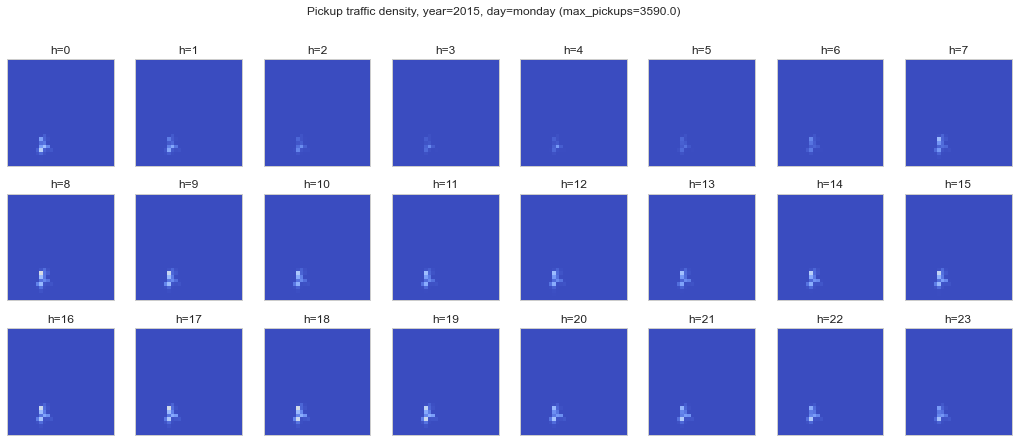

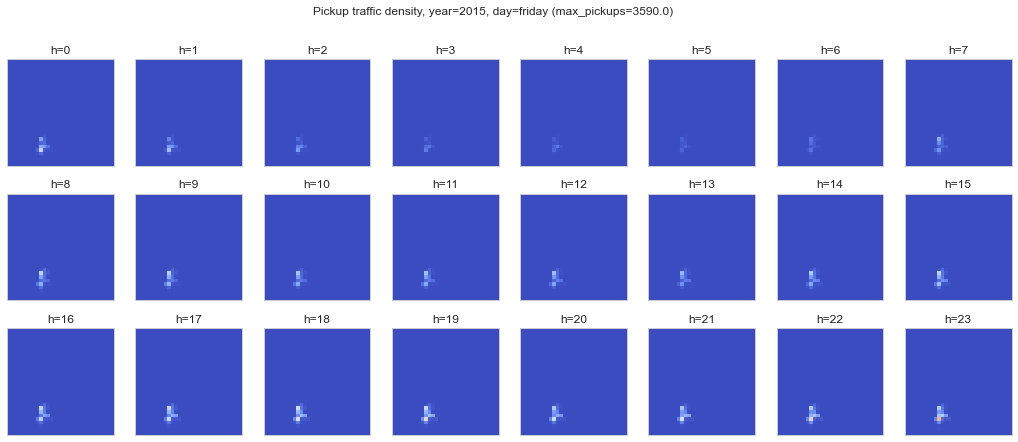

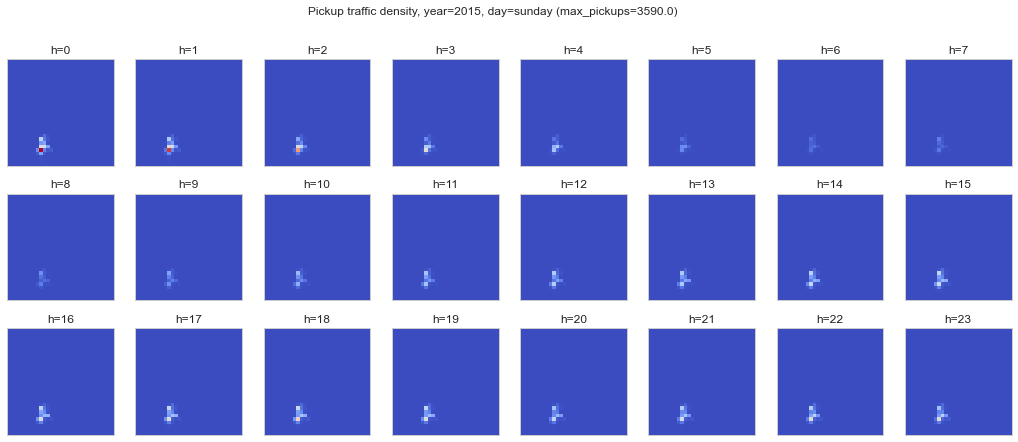

In [27]:
plot_traffic(traffic, 2015, 'monday')
plot_traffic(traffic, 2015, 'friday')
plot_traffic(traffic, 2015, 'sunday')

## Distance and time visualisations

Before building a model I want to test some basic 'intuition':

- The longer the distance between pickup and dropoff location, the higher the fare.
- Some trips, like to/from an airport, are fixed fee. 
- Fare at night is different from day time.

So, let's check.

### The longer the distance between pickup and dropoff location, the higher the fare

To visualize the distance - fare relation we need to calculate the distance of a trip first. 

count    998236.000000
mean          2.905731
std           2.954355
min           0.000000
25%           1.090000
50%           1.930000
75%           3.670000
max         121.050000
Name: trip_distance, dtype: float64

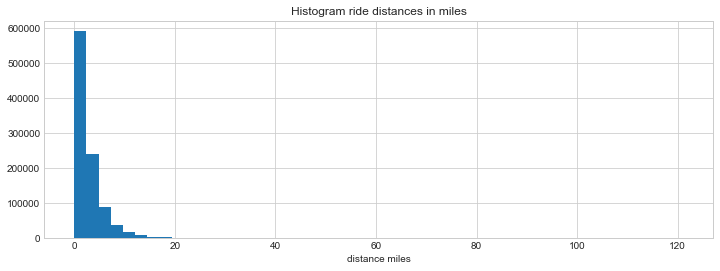

In [28]:
# add new column to dataframe with distance in miles
gdf.trip_distance.hist(bins=50, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')
gdf.trip_distance.describe()

It seems that most rides are just short rides, with a small peak at ~3 miles.
Let's also see the influence of `passenger_count`.

In [29]:
gdf.groupby(['passenger_count','trip_distance', 'fare_amount']).mean()

rate_code  pickup_longitude  \
passenger_count trip_distance fare_amount                                
1               0.00          0.00              2.48        -73.917397   
                              0.01               5.0        -73.931686   
                              0.02               5.0        -73.900241   
                              0.04               5.0        -73.954048   
                              0.05               5.0        -73.870756   
...                                              ...               ...   
9               0.00          11.80              5.0        -73.954849   
                              80.00              5.0        -74.125137   
                0.10          9.80               5.0        -73.865440   
                0.89          9.00               5.0        -73.809669   
                6.05          25.00              5.0        -73.913612   

                                           pickup_latitude  dropoff_longitude  \
passenger_count trip_distance fare_amount                                       
1               0.00          0.00               40.770695         -73.917416   
                              0.01               40.779707         -73.931685   
                              0.02               40.765770         -73.900243   
                              0.04               40.587318         -73.954063   
                              0.05               40.734220         -73.870778   
...                                                    ...                ...   
9               0.00          11.80              40.671097         -73.954849   
                              80.00              40.623013         -74.125137   
                0.10          9.80               40.837101         -73.865112   
                0.89          9.00               40.698147         -73.819489   
                6.05          25.00              40.845356         -73.950699   

                                           dropoff_latitude   extra  mta_tax  \
passenger_count trip_distance fare_amount                                      
1               0.00          0.00                40.770677  0.0025    0.015   
                              0.01                40.779743  0.0000    0.000   
                              0.02                40.765812  0.0000    0.000   
                              0.04                40.587318  0.0000    0.000   
                              0.05                40.734249  0.0000    0.000   
...                                                     ...     ...      ...   
9               0.00          11.80               40.671093  0.0000    0.000   
                              80.00               40.623013  0.0000    0.000   
                0.10          9.80                40.835457  0.0000    0.000   
                0.89          9.00                40.701962  0.0000    0.000   
                6.05          25.00               40.800522  0.0000    0.000   

                                           tip_amount  tolls_amount  \
passenger_count trip_distance fare_amount                             
1               0.00          0.00             0.8475        0.5027   
                              0.01             0.0000        0.0000   
                              0.02             0.0000        0.0000   
                              0.04             0.0000        0.0000   
                              0.05             0.0000        0.0000   
...                                               ...           ...   
9               0.00          11.80            0.0000        0.0000   
                              80.00           16.0000        0.0000   
                0.10          9.80             0.0000        0.0000   
                0.89          9.00             0.0000        0.0000   
                6.05          25.00            0.0000        0.0000   

                                           total_amount  ... 

A `passenger_count` of zero seems odd. Perhaps a taxi transporting some goods or an administration error? The latter seems not the case as the `fare_amount` is also significantly lower.

Instead of looking to the `fare_amount` using the 'fare per mile' also provides some insights.

In [30]:
print("Average $USD/Mile : {:0.2f}".format(gdf.fare_amount.sum()/gdf.trip_distance.sum()))

Average $USD/Mile : 4.31


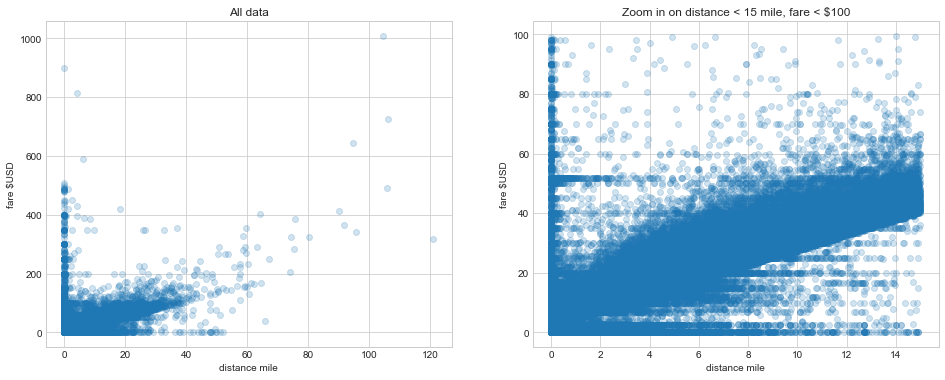

In [31]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(gdf.trip_distance, gdf.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance mile')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')

# zoom in on part of data
idx = (gdf.trip_distance < 15) & (gdf.fare_amount < 100)
axs[1].scatter(gdf[idx].trip_distance, gdf[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance mile')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 15 mile, fare < $100');

From this plot we notice:

- There are trips with zero distance but with a non-zero fare. Could this be trips from and to the same location? Predicting these fares will be difficult as there is likely not sufficient information in the dataset.  They may also be due to cabbies not reporting distance but reporting a fare.  
- There are some trips with >25 miles travel distance but low fare. 
- The horizontal lines in the right plot might indicate again the fixed fare trips to/from JFK airport.
- Overall there seems to be a (linear) relation between distance and fare with an average rate of +/- 100/20 = 5 \$USD/mile.


In [32]:
# remove datapoints with distance <0.05 milesf
idx = (gdf.trip_distance >= 0.05)
print('Old size: %d' % len(gdf))
gdf = gdf[idx]
print('New size: %d' % len(gdf))

Old size: 998236


New size: 983790


## Some trips, like to/from an airport, are fixed fee

Another way to explore this data is to check trips to/from well known places. E.g. a trip to JFK airport. Depending on the distance, a trip to an airport is often a fixed price. Let's see.

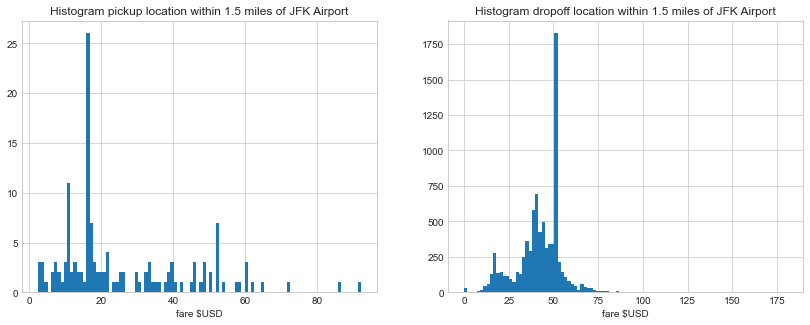

In [33]:
# JFK airport coordinates, see https://www.travelmath.com/airport/JFK
jfk = (-73.7822222222, 40.6441666667)
nyc = (-74.0063889, 40.7141667)

def plot_location_fare(loc, name, range=1.5):
    # select all datapoints with dropoff location within range of airport
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    idx = (distance(gdf.pickup_latitude, gdf.pickup_longitude, loc[1], loc[0]) < range)
    gdf[idx].fare_amount.hist(bins=100, ax=axs[0])
    axs[0].set_xlabel('fare $USD')
    axs[0].set_title('Histogram pickup location within {} miles of {}'.format(range, name))

    idx = (distance(gdf.dropoff_latitude, gdf.dropoff_longitude, loc[1], loc[0]) < range)
    gdf[idx].fare_amount.hist(bins=100, ax=axs[1])
    axs[1].set_xlabel('fare $USD')
    axs[1].set_title('Histogram dropoff location within {} miles of {}'.format(range, name))
    
plot_location_fare(jfk, 'JFK Airport')

The majority of rides seem to be going to the airport in this set.  The price is probably fxed around 55-60 dollars.  The price from the airport to manhattan is probably around 25-27 dollars.  

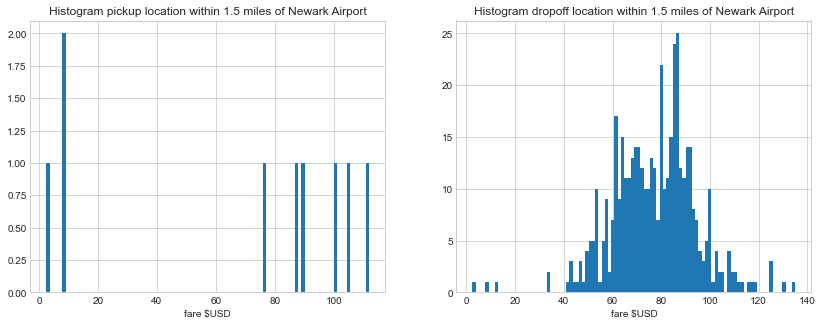

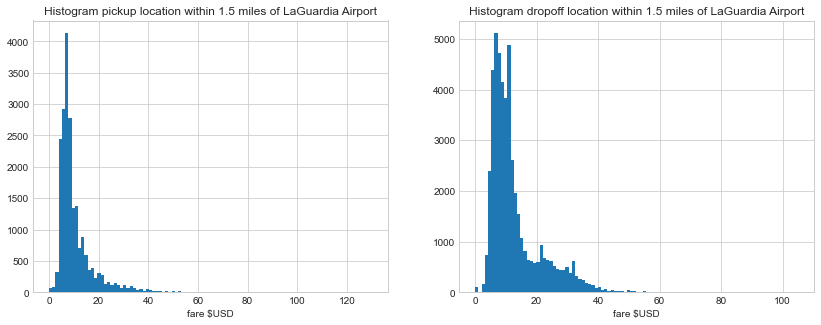

In [34]:
ewr = (-74.175, 40.69) # Newark Liberty International Airport, see https://www.travelmath.com/airport/EWR
lgr = (-73.87, 40.77) # LaGuardia Airport, see https://www.travelmath.com/airport/LGA
plot_location_fare(ewr, 'Newark Airport')
plot_location_fare(lgr, 'LaGuardia Airport')

Trips from newark are rare.  Trips from newark are occasionl.  Laguardia pickpus and dropoff rates ae nearly identical.  Interestingly there are more dropoffs to the airport.  The rate is farely normal, with shifting fares it seems according to distance I assume.  

## Fare at night is different from day time

To visualize the relation between time and fare/km three more columns are added to the data: the year, the hour of the day and the fare $USD per KM.

In [35]:
# Lambada ensure that memory issues do not arise from improperly copying. It takes forever though.  I could probaly vectorize the function. 

gdf['fare_per_mile'] = gdf.apply(lambda x: x.fare_amount/x.trip_distance, axis = 1)
gdf.fare_per_mile.describe()

count    983790.000000
mean          5.874245
std          25.184516
min           0.000000
25%           4.000000
50%           4.852321
75%           6.000000
max        7000.000000
Name: fare_per_mile, dtype: float64

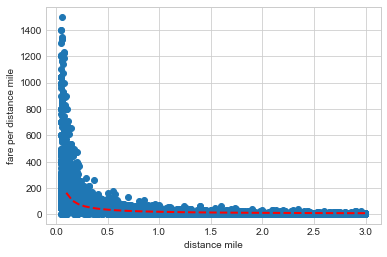

In [36]:
idx = (gdf.trip_distance < 3) & (gdf.fare_amount < 100)
plt.scatter(gdf[idx].trip_distance, gdf[idx].fare_per_mile)
plt.xlabel('distance mile')
plt.ylabel('fare per distance mile')

# theta here is estimated by hand
theta = (16, 4.0)
x = np.linspace(0.1, 3, 50)
plt.plot(x, theta[0]/x + theta[1], '--', c='r', lw=2);

There is a large spread at low distances. Probably due to slow traffic.  There is also some values reported as high as 1400.  I assume this is due to cabbies padding and cleaning their earnings.

Let's continue with the time vs fare per distance analysis. Next we use a pandas pivot table to calculate a summary and to plot them.

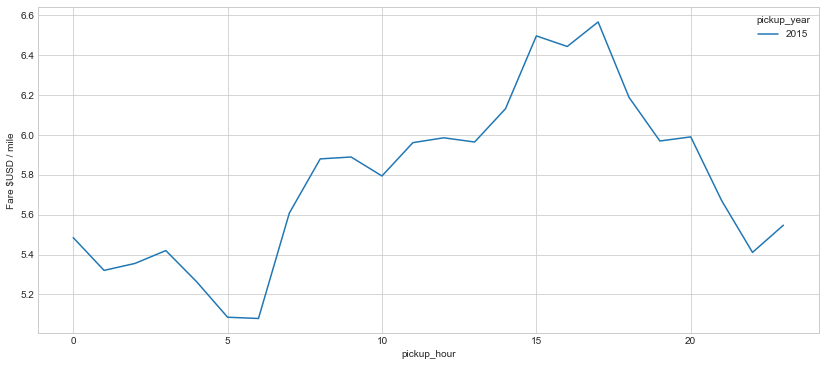

In [37]:
# display pivot table
gdf.pivot_table('fare_per_mile', index='pickup_hour', columns='pickup_year').plot(figsize=(14,6))
plt.ylabel('Fare $USD / mile');

It can be clearly seen that the fare $USD/mile varies over the hour. 

A more in-depth analysis of the fare / time dependency is illustrated below. Here, I calculate per year and per hour the fare and do a linear regression. When investigating the plots, you clearly see the price increase over the years.

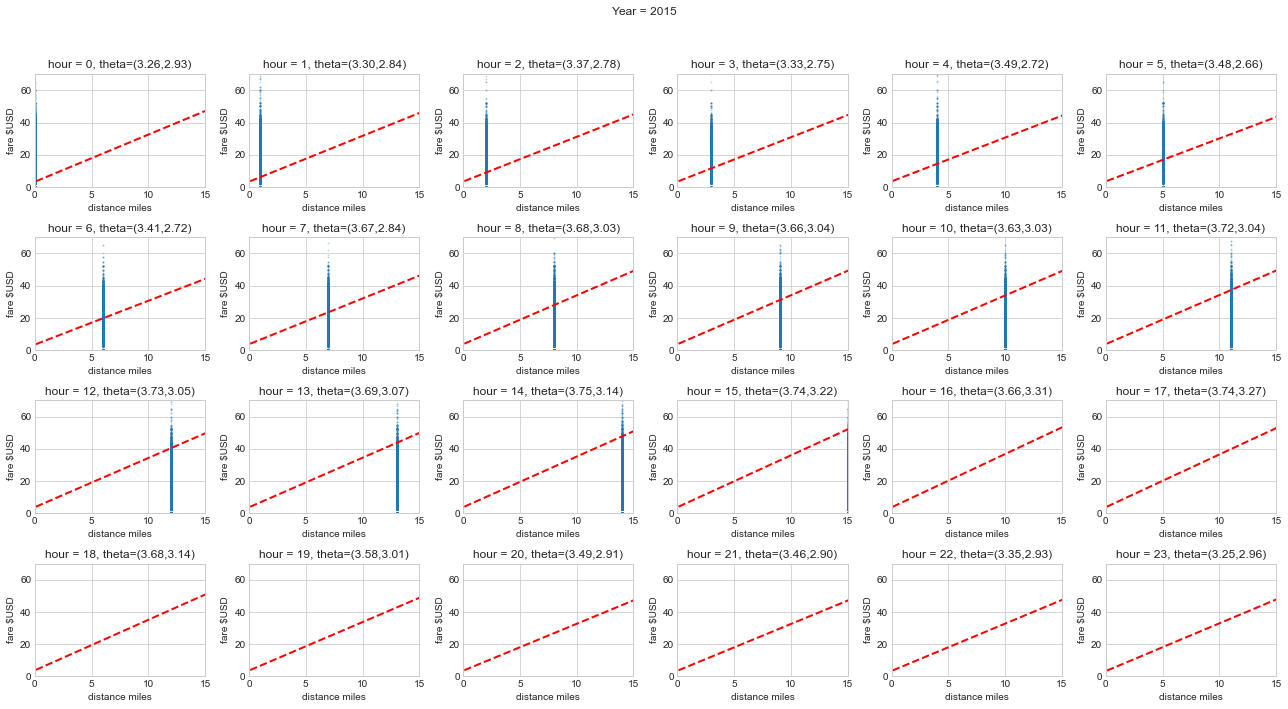

In [38]:
from sklearn.linear_model import LinearRegression

# plot all years
for year in gdf.pickup_year.unique():
    # create figure
    fig, axs = plt.subplots(4, 6, figsize=(18, 10))
    axs = axs.ravel()
    
    # plot for all hours
    for h in range(24):
        idx = (gdf.trip_distance < 15) & (gdf.fare_amount < 100) & (gdf.pickup_hour == h) & \
              (gdf.pickup_year == year)
        axs[h].scatter(gdf[idx].pickup_hour, gdf[idx].fare_amount, alpha=0.2, s=1)
        axs[h].set_xlabel('distance miles')
        axs[h].set_ylabel('fare $USD')
        axs[h].set_xlim((0, 15))
        axs[h].set_ylim((0, 70))

        model = LinearRegression(fit_intercept=False)
        x, y = gdf[idx].trip_distance.values.reshape(-1,1), gdf[idx].fare_amount.values.reshape(-1,1)
        X = np.concatenate((np.ones(x.shape), x), axis=1)
        model.fit(X, y)
        xx = np.linspace(0.1, 25, 100)
        axs[h].plot(xx, model.coef_[0][0] + xx * model.coef_[0][1], '--', c='r', lw=2)
        axs[h].set_title('hour = {}, theta=({:0.2f},{:0.2f})'.format(h, model.coef_[0][0], model.coef_[0][1]))

    plt.suptitle("Year = {}".format(year))
    plt.tight_layout(rect=[0, 0, 1, 0.95])

## Fare varies with pickup location

To visualize whether the fare per km varies with the location the distance to the center of New York is calculated. 

In [39]:
# add new column to dataframe with distance in mile
gdf['distance_to_center'] = distance(nyc[1], nyc[0], gdf.pickup_latitude, gdf.pickup_longitude)

Plotting the distance to NYC center vs distance of the trip vs the fare amount gives some insight in this complex relation. 

/var/folders/kw/lt24g6yd1ml1zznc5n22lbb00000gn/T/ipykernel_15204/3705102942.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im, ax=axs[0])


/var/folders/kw/lt24g6yd1ml1zznc5n22lbb00000gn/T/ipykernel_15204/3705102942.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im, ax=axs[1])


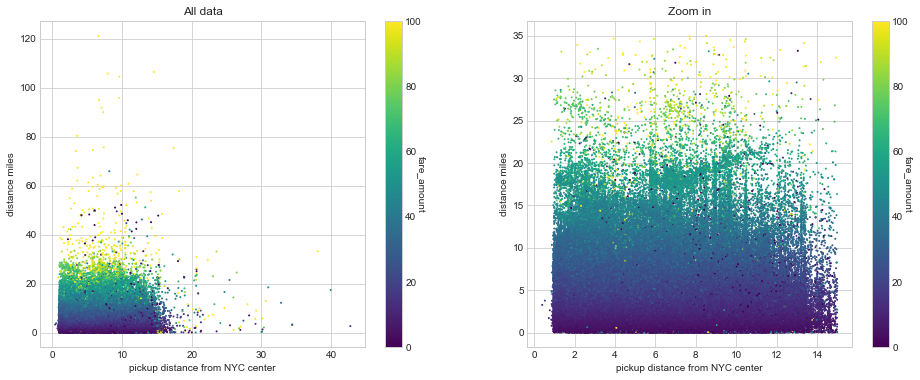

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
im = axs[0].scatter(gdf.distance_to_center, gdf.trip_distance, c=np.clip(gdf.fare_amount, 0, 100), 
                     cmap='viridis', alpha=1.0, s=1)
axs[0].set_xlabel('pickup distance from NYC center')
axs[0].set_ylabel('distance miles')
axs[0].set_title('All data')
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel('fare_amount', rotation=270)

idx = (gdf.distance_to_center < 15) & (gdf.trip_distance < 35)
im = axs[1].scatter(gdf[idx].distance_to_center, gdf[idx].trip_distance, 
                     c=np.clip(gdf[idx].fare_amount, 0, 100), cmap='viridis', alpha=1.0, s=1)
axs[1].set_xlabel('pickup distance from NYC center')
axs[1].set_ylabel('distance miles')
axs[1].set_title('Zoom in')
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel('fare_amount', rotation=270);

There are a lot of 'green' dots, which is about \$50 to \$60 fare amount near 13 miles distance of NYC center of distrance of trip. This could be due to trips from/to JFK airport. Let's remove them to see what we're left with.

In [41]:
gdf['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0], gdf.pickup_latitude, gdf.pickup_longitude)
gdf['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0], gdf.dropoff_latitude, gdf.dropoff_longitude)

/var/folders/kw/lt24g6yd1ml1zznc5n22lbb00000gn/T/ipykernel_15204/1958965034.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im, ax=axs[0])


/var/folders/kw/lt24g6yd1ml1zznc5n22lbb00000gn/T/ipykernel_15204/1958965034.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im, ax=axs[1])


Text(0, 0.5, 'fare_amount')

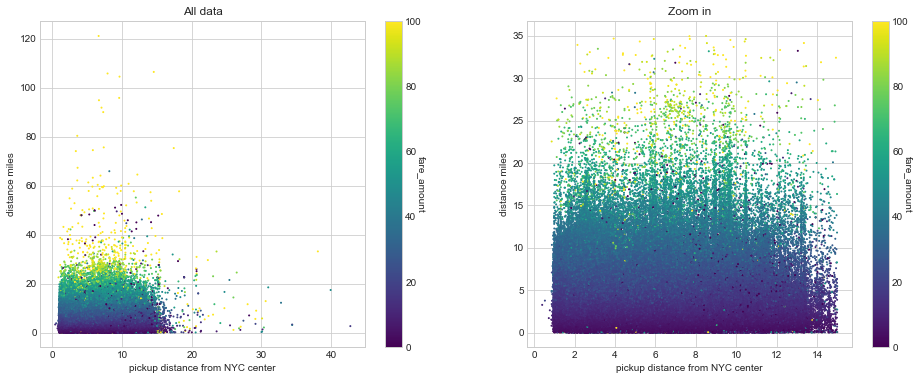

In [42]:
# remove all to/from JFK trips
idx = ~((gdf.pickup_distance_to_jfk < 1) | (gdf.dropoff_distance_to_jfk < 1))

fig, axs = plt.subplots(1, 2, figsize=(16,6))
im = axs[0].scatter(gdf[idx].distance_to_center, gdf[idx].trip_distance, 
                    c=np.clip(gdf[idx].fare_amount, 0, 100), 
                     cmap='viridis', alpha=1.0, s=1)
axs[0].set_xlabel('pickup distance from NYC center')
axs[0].set_ylabel('distance miles')
axs[0].set_title('All data')
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel('fare_amount', rotation=270)

idx1 = idx & (gdf.distance_to_center < 15) & (gdf.trip_distance < 35)
im = axs[1].scatter(gdf[idx1].distance_to_center, gdf[idx1].trip_distance, 
                     c=np.clip(gdf[idx1].fare_amount, 0, 100), cmap='viridis', alpha=1.0, s=1)
axs[1].set_xlabel('pickup distance from NYC center')
axs[1].set_ylabel('distance miles')
axs[1].set_title('Zoom in')
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel('fare_amount', rotation=270)

Now there are some 'yellow' dots (fare amount > \$80) left. To understand these datapoints we plot them on the map.

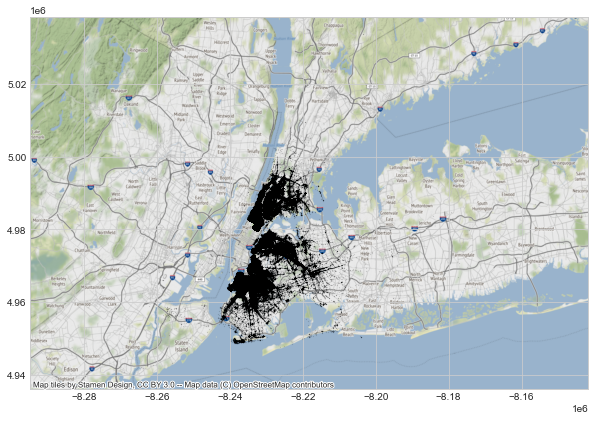

In [43]:
idx = (gdf.fare_amount>80) & (gdf.trip_distance<35) 
gdf[idx]
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', markersize = .01)
cx.add_basemap(ax)

There are a surpsing numbder of data points.  
I'll remove all of the airports just to see what is left.


In [44]:
gdf['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0], gdf.pickup_latitude, gdf.pickup_longitude)
gdf['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0],gdf.dropoff_latitude,gdf.dropoff_longitude)
gdf['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0], gdf.pickup_latitude, gdf.pickup_longitude)
gdf['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0],gdf.dropoff_latitude,gdf.dropoff_longitude)

/var/folders/kw/lt24g6yd1ml1zznc5n22lbb00000gn/T/ipykernel_15204/1133551596.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im, ax=axs[0])


/var/folders/kw/lt24g6yd1ml1zznc5n22lbb00000gn/T/ipykernel_15204/1133551596.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im, ax=axs[1])


Text(0, 0.5, 'fare_amount')

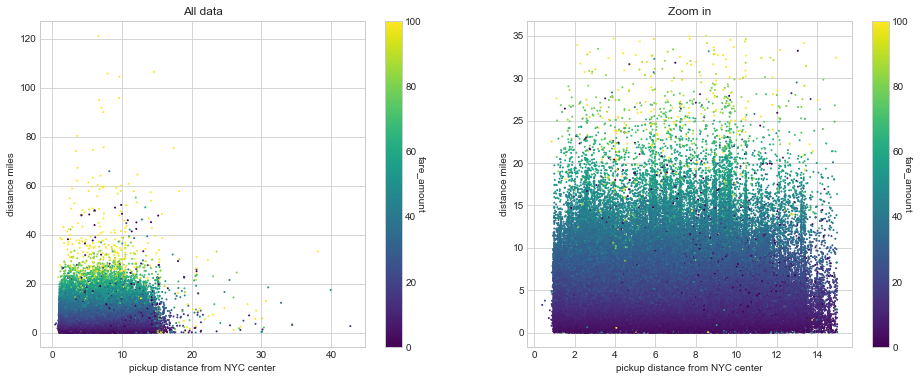

In [45]:
# remove all to/from airport trips
idx = ~((gdf.pickup_distance_to_jfk < 1) | (gdf.dropoff_distance_to_jfk < 1) |
        (gdf.pickup_distance_to_ewr < 1) | (gdf.dropoff_distance_to_ewr < 1) |
        (gdf.pickup_distance_to_lgr < 1) | (gdf.dropoff_distance_to_lgr < 1))

fig, axs = plt.subplots(1, 2, figsize=(16,6))
im = axs[0].scatter(gdf[idx].distance_to_center, gdf[idx].trip_distance, 
                    c=np.clip(gdf[idx].fare_amount, 0, 100), 
                     cmap='viridis', alpha=1.0, s=1)
axs[0].set_xlabel('pickup distance from NYC center')
axs[0].set_ylabel('distance miles')
axs[0].set_title('All data')
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel('fare_amount', rotation=270)

idx1 = idx & (gdf.distance_to_center < 15) & (gdf.trip_distance < 35)
im = axs[1].scatter(gdf[idx1].distance_to_center, gdf[idx1].trip_distance, 
                     c=np.clip(gdf[idx1].fare_amount, 0, 100), cmap='viridis', alpha=1.0, s=1)
axs[1].set_xlabel('pickup distance from NYC center')
axs[1].set_ylabel('distance miles')
axs[1].set_title('Zoom in')
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel('fare_amount', rotation=270)

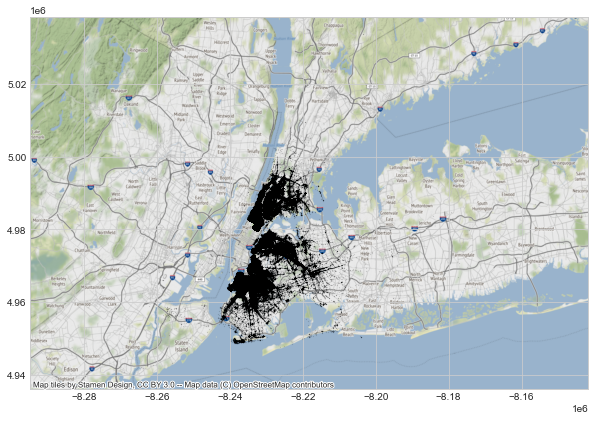

In [46]:
idx = idx = ~((gdf.pickup_distance_to_jfk < 1) | (gdf.dropoff_distance_to_jfk < 1) |
        (gdf.pickup_distance_to_ewr < 1) | (gdf.dropoff_distance_to_ewr < 1) |
        (gdf.pickup_distance_to_lgr < 1) | (gdf.dropoff_distance_to_lgr < 1))
gdf[idx]
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', markersize = .01)
cx.add_basemap(ax)

In [47]:
idx = ~((gdf.pickup_distance_to_jfk < 1) | (gdf.dropoff_distance_to_jfk < 1) |
        (gdf.pickup_distance_to_ewr < 1) | (gdf.dropoff_distance_to_ewr < 1) |
        (gdf.pickup_distance_to_lgr < 1) | (gdf.dropoff_distance_to_lgr < 1))
gdf[idx]

pickup_datetime           dropoff_datetime  \
0       2015-06-30T16:11:08+00:00  2015-06-30T16:18:33+00:00   
1       2015-06-30T14:06:56+00:00  2015-06-30T14:44:59+00:00   
2       2015-06-30T08:50:52+00:00  2015-06-30T08:56:16+00:00   
3       2015-06-30T03:55:39+00:00  2015-06-30T04:09:03+00:00   
4       2015-06-30T01:38:08+00:00  2015-06-30T01:55:25+00:00   
...                           ...                        ...   
999993  2015-06-12T19:55:24+00:00  2015-06-12T20:00:56+00:00   
999996  2015-06-12T14:03:49+00:00  2015-06-12T14:23:32+00:00   
999997  2015-06-12T19:17:17+00:00  2015-06-12T19:21:12+00:00   
999998  2015-06-12T10:01:36+00:00  2015-06-12T10:10:51+00:00   
999999  2015-06-12T08:00:53+00:00  2015-06-12T08:15:21+00:00   

       store_and_fwd_flag  rate_code  pickup_longitude  pickup_latitude  \
0                       N          1        -73.943321        40.785267   
1                       N          1        -73.951302        40.689251   
2                       N          1        -73.944077        40.721775   
3                       N          1        -73.854630        40.742798   
4                       N          1        -73.910698        40.658485   
...                   ...        ...               ...              ...   
999993                  N          1        -73.942421        40.724537   
999996                  N          1        -73.949120        40.785156   
999997                  N          1        -73.954285        40.811398   
999998                  N          1        -73.946907        40.819260   
999999                  N          1        -73.948685        40.823864   

        dropoff_longitude  dropoff_latitude  passenger_count  trip_distance  \
0              -73.935303         40.800449                1           1.49   
1              -73.999634         40.634769                1           5.74   
2              -73.944504         40.714703                1           0.63   
3              -73.905746         40.747269                2           3.26   
4              -73.971657         40.697437                1           5.35   
...                   ...               ...              ...            ...   
999993         -73.954918         40.730190                1           1.10   
999996         -73.962090         40.757912                1           2.68   
999997         -73.960075         40.810703                1           0.43   
999998         -73.943138         40.840080                1           1.70   
999999         -73.969780         40.793877                1           2.50   

        ...  pickup_codes  dropoff_codes  fare_per_mile  distance_to_center  \
0       ...             1              1       4.697987            5.918672   
1       ...             1              1       4.442509            3.360027   
2       ...             1              1       7.936508            3.305239   
3       ...             1              1       3.834356            8.188606   
4       ...             1              1       3.364486            6.319518   
...     ...           ...            ...            ...                 ...   
999993  ...             4              4       5.454545            3.425569   
999996  ...             4              4       5.597015            5.748388   
999997  ...             4              4       9.302326            7.250292   
999998  ...             4              4       5.000000            7.900250   
999999  ...             4              4       4.600000            8.158682   

        pickup_distance_to_jfk  dropoff_distance_to_jfk  \
0                    12.892809                13.448219   
1                     9.392720                11.417274   
2                    10.033491                 9.800867   
3                     7.799317                 9.623856   
4                     6.807010                10.587665   
...                        ...                      ...   
999993               10.064154       

Removing the to/from airport trips doesn't really change the outcome of the data.  The number of trips to the airports from the boroughs is less than I thought.  

## Final Thoughts

Very few of these cabs operatine in Manhattan. I was confused hy this. I found that most green cabs operate in the boroughs.  The few number of these going to the center, accounted for such high rates as this is not their typical range of operation. 
